In [29]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

plt.rc('figure', figsize=[13,7]) #Diagramm size

h_bar = 1.0545718*10**-34 #hbar
m_e   = 9.10938356*10**-31 #m_e
mu_b  = 9.274009994*10**-24 #mu_b

x0    = 1.22085284*10**-38 #hbar^2/m_e
x1    = 1.60218*10**-22 #meV
x2    = 1.60218*10**-29 #eVÅ
x3    = 1*10*-6 #mum
x4    = 10**7 #k


def I(start,end,steps,edge_points=True): #Intervall
    if edge_points==True:
        return [start+i*(end-start)/(steps-1) for i in range(steps)]
    else:
        return [start+(i+1)*(end-start)/(steps+1) for i in range(steps)]
    
def sort_eigenValues(A,absolute=False): #Sorting eigenvalues
    eigenValues, eigenVectors = np.linalg.eigh(A)
    if absolute==True:
        idx = np.argsort(abs(eigenValues))
    if absolute==False:
        idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return [eigenValues,eigenVectors]

def V(x,v): #Potential "inf quantum well"
    if abs(x)>1:
        return v
    else:
        return 0
    
def H(start_x,end_x,steps_x,v,m=0.012*m_e): #Matrix Numerov "inf quantum well"
    X = np.zeros((steps_x,steps_x))
    Y = I(start_x,end_x,steps_x,edge_points=False)
    d=(end_x-start_x)/(steps_x+1)
    for z in range(steps_x):
        X[z,z] = (h_bar**2)/m/((d)**2)+V(Y[z],v)
        if z<steps_x-1:
            X[z,z+1]=-(h_bar**2)/m/((d)**2)/2
            X[z+1,z]=-(h_bar**2)/m/((d)**2)/2
    return X 

def E(n,m=0.012*m_e):#Analytic E
    return [h_bar**2*np.pi**2/8*(i+1)**2/m for i in range(n)]

def Psi(x,n,m=0.012*m_e): #Analytic eigenfunction (not normalized)
    k = n*np.pi/2
    return np.sin(k*(x+1))

def Plot_Numerov(start_x,end_x,steps_x,v,number_plot_eigenfunction=3):#Plot Numerov for "inf quantum well"
    X = I(start_x,end_x,steps_x,edge_points=False)
    M =sort_eigenValues(H(start_x,end_x,steps_x,v),absolute=False)
    l=0
    while M[0][l]<v:
        l +=1
    l +=-1
    Y=np.array(E(l))
    plt.plot([i+1 for i in range(l)],[M[0][i]*10**32 for i in range(l)],c='r')
    plt.plot([i+1 for i in range(l)],Y*10**32,c='b')
    plt.xlabel('n')
    plt.ylabel('E [$10^{-32}$ J]')
    plt.legend(["Numeric $E_n$","Analytic $E_n$"],loc="upper left")
    plt.title("Numeric $E_n$ vs. Analytic $E_n$")
    plt.show()
    plt.plot([i+1 for i in range(l)],[abs(M[0][i]-Y[i])/Y[i]*100 for i in range(l)],c='k')
    plt.title("Relative error")
    plt.xlabel('n')
    plt.ylabel('%')
    plt.show()
    for i in range(min(number_plot_eigenfunction,l)):
        plt.plot(X,M[1][:,i]**2*max(Psi(np.linspace(-1,1,1000),i+1)**2)/max(M[1][:,i])**2,'r')
        plt.plot(np.linspace(-1,1,1000),Psi(np.linspace(-1,1,1000),i+1)**2,'--b',alpha=0.5)
        plt.xlim(-1.1,1.1)
        plt.xlabel('x')
        plt.ylabel('$|\Psi|^2$')
        plt.title("Eigenfunction for $E_{%d}$" %(i+1))
        plt.yticks([0])
        plt.legend(["Numeric $|\Psi|^2$","Analytic $|\Psi|^2$"],loc="upper left")
        plt.show()


def V0(m,a):
    return h_bar**2/(m*(a)**2)

def V1(g,B,l,x):
    if abs(x)>l:
        return 0
    else:
        return g*mu_b*B

def V2(mu,l,x):
    if abs(x)>l:
        return 0
    else:
        return mu
    
def V3(v,l,x):
    if abs(x)>l:
        return v
    else:
        return 0
    
def V4(delta,l,x):
    if abs(x)>l:
        return 0
    else:
        return delta
    
def V5(alpha,a,l,x):
    if abs(x)>l:
        return 0
    else:
        return alpha/(2*a)
    

def M(m,g,B,delta,alpha,mu,l,n,d=0, v=0,delta_zero_mode=False): #Matrix Numerov for H_2
    m=m*m_e
    delta=delta*x1
    alpha=alpha*x2
    mu=mu*x1
    v=v*x1
    if delta_zero_mode==True:
        delta=np.sqrt((g*mu_b*B)**2-(mu*x1)**2)
    X = np.zeros((4*n,4*n))
    Y = I(-l-d,l+d,n,False)
    a = 2*(l+d)/(n+1)
    for z in range(n):
        X[z,z] = V0(m,a) + V1(g,B,l,Y[z]) - V2(mu,l,Y[z]) + V3(v,l,Y[z])
        X[z+n,z+n] = V0(m,a) - V1(g,B,l,Y[z]) - V2(mu,l,Y[z]) + V3(v,l,Y[z])
        X[z+2*n,z+2*n] = -V0(m,a) + V1(g,B,l,Y[z]) + V2(mu,l,Y[z]) - V3(v,l,Y[z])
        X[z+3*n,z+3*n] = -V0(m,a) - V1(g,B,l,Y[z]) + V2(mu,l,Y[z]) - V3(v,l,Y[z])
        X[z,z+2*n] = V4(delta,l,Y[z])
        X[z+n,z+3*n] = V4(delta,l,Y[z])
        X[z+2*n,z] = V4(delta,l,Y[z])
        X[z+3*n,z+n] = V4(delta,l,Y[z])
        if z<n-1:
            X[z,z+1] = -V0(m,a)/2
            X[z+1,z] = -V0(m,a)/2
            X[z+n,z+1+n] = -V0(m,a)/2
            X[z+1+n,z+n] = -V0(m,a)/2
            X[z+2*n,z+1+2*n] = V0(m,a)/2
            X[z+1+2*n,z+2*n] = V0(m,a)/2
            X[z+3*n,z+1+3*n] = V0(m,a)/2
            X[z+1+3*n,z+3*n] = V0(m,a)/2
            X[z,z+n+1] = V5(alpha,a,l,Y[z+1])
            X[z+1,z+n]= -V5(alpha,a,l,Y[z])
            X[z+n,z+1]= -V5(alpha,a,l,Y[z+1])
            X[z+n+1,z]= V5(alpha,a,l,Y[z])
            X[z+2*n,z+3*n+1]= -V5(alpha,a,l,Y[z+1])
            X[z+2*n+1,z+3*n]= V5(alpha,a,l,Y[z])
            X[z+3*n,z+2*n+1]= V5(alpha,a,l,Y[z+1])
            X[z+3*n+1,z+2*n]=-V5(alpha,a,l,Y[z])
    return X

def same_absolute_value(M): #Calculates number of same absolute eigenvalues 
    t = []
    for x in range(len(M[0])-1):
        if abs(abs(M[0][x])-abs(M[0][x+1]))/x1>0.1:
            t.append(x)
    return t

def Plot_E(m,g,B,delta,alpha,mu,l,n,d,v,delta_zero_mode=False): #Plot energie H_2
    t=sort_eigenValues(M(m,g,B,delta,alpha,mu,l,n,d, v,delta_zero_mode),absolute=True)
    x = np.linspace(-1,1,10)
    for y in range(len(t[0])):
        plt.plot(x,[t[0][y]/v1 for i in range(len(x))],'k')
    plt.ylabel('E [meV]')
    plt.xticks([])
    z=t[0][same_absolute_value(t)[1]]*1.2/v1
    plt.ylim(-z,z)
    if delta_zero_mode==True:
        delta=np.sqrt((g*mu_b*B)**2-(mu*x1)**2)/x1
    plt.legend(['$m^*$ = %.3f $m_e$'%m,'α    = %.1f eVÅ'%alpha,'g    = %d'%g,'B    = %.1f T'%B,'Δ    = %.1f meV'%delta,'μ    = %.2f meV'%mu],loc="lower left",handlelength=0)
    plt.show()
    
###### work in progress
###### work in progress
###### work in progress
###### work in progress

def Plot_wavefunction(m,g,B,delta,alpha,mu,l,n,d,v,delta_zero_mode=False,spin='down'): #Plot wavefunction spin up Majorana 1
    X0 = sort_eigenValues(M(m,g,B,delta,alpha,mu,l,n,d,v,delta_zero_mode),absolute=True)
    if spin=='up':
        s=0
    if spin=='down':
        s=1
    X1 = np.array(I(-l-d,l+d,n,False)) 
    for x in range(20):
        X2=np.array([(X0[1][i+s*n][x]+X0[1][i+(s+2)*n][x])**2 for i in range(len(X1))])
        X11 = X1[X2 > max(X2)*10e-6]
        X21 = X2[X2 > max(X2)*10e-6]
        plt.plot(X11,X21)
    if delta_zero_mode==True:
        delta=np.sqrt((g*mu_b*B)**2-(mu*x1)**2)/x1
    plt.legend(['$m^*$ = %.3f $m_e$'%m,'α    = %.1f eVÅ'%alpha,'g    = %d'%g,'B    = %.1f T'%B,'Δ    = %.1f meV'%delta,'μ    = %.2f meV'%mu],loc="lower left",handlelength=0)
    plt.xlabel('x')
    plt.ylabel('$|\gamma_1|^2$')
    plt.yticks([0])
    plt.show()
    for x in range(20):
        X3=np.array([(X0[1][i+s*n][x]-X0[1][i+(s+2)*n][x])**2 for i in range(len(X1))])
        if s==1:
            plt.plot(X1,X3)
        else:
            X11 = X1[X3 > max(X3)*10e-6]
            X31 = X3[X3 > max(X3)*10e-6]
            plt.plot(X11,X31)
    plt.legend(['$m^*$ = %.3f $m_e$'%m,'α    = %.1f eVÅ'%alpha,'g    = %d'%g,'B    = %.1f T'%B,'Δ    = %.1f meV'%delta,'μ    = %.2f meV'%mu],loc="lower left",handlelength=0)
    plt.xlabel('x')
    plt.ylabel('$|\gamma_2|^2$')
    plt.yticks([0])
    plt.show()
    


def PlotE3(m,g,B,alpha,mu,l,n,d,v,start_delta,end_delta,steps_delta,delta_zero_mode=False,wf=0):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    X0 = I(start_delta,end_delta,steps_delta,True)
    Y0 = I(-l-d,l+d,n,False)
    X1, Y1 = np.meshgrid(X0, Y0)
    Z2 = np.zeros((n,steps_delta))
    print(B*mu_b*g/x1)
    for z3 in range(steps_delta):
        Z4 = sort_eigenValues(M(m,g,B,X0[z3],alpha,mu,l,n,d,v,delta_zero_mode),absolute=True)
        #Z5 = PlotE0(Z4)
        for z5 in range(n):
            for z6 in range(100):
                if wf==0:
                    Z2[z5][z3]=max(Z2[z5][z3],(Z4[1][z5][z6]+Z4[1][z5+2*n][z6])**2)
                if wf==1:
                    Z2[z5][z3]=max(Z2[z5][z3],(Z4[1][z5][z6]-Z4[1][z5+2*n][z6])**2)
                if wf==2:
                    Z2[z5][z3]=max(Z2[z5][z3],(Z4[1][z5+n][z6]+Z4[1][z5+3*n][z6])**2)
                if wf==3:
                    Z2[z5][z3]=max(Z2[z5][z3],(Z4[1][z5+n][z6]-Z4[1][z5+3*n][z6])**2)
        surf = ax.plot_surface(X1, Y1, Z2, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(50,40)
    ax.set_xlabel('$\Delta$')
    ax.set_ylabel('x')
    ax.set_zlabel('|Psi|^2')
    plt.show()

#PlotE3(m=0.012,g=45,B=27.7165,delta=20,alpha=1.5,mu=0,l=0.5,n=100,d=0.1, v=100,c=0,B_s=-5,B_e=10,B_n=200)


def Plot_wavefunction1(m,g,B,delta,alpha,mu,l,n,d,v,delta_zero_mode=False,spin='down'): #Plot wavefunction spin up Majorana 1
    X0 = sort_eigenValues(M(m,g,B,delta,alpha,mu,l,n,d,v,delta_zero_mode),absolute=True)
    if spin=='up':
        s=0
    if spin=='down':
        s=1
    X1 = np.array(I(-l-d,l+d,n,False))
    X2=[0 for i in range(len(X1))]
    for x in range(30):
        if X0[0][x]<0:
            X2=[max(X2[i],(X0[1][i+s*n][x]+X0[1][i+(s+2)*n][x])**2) for i in range(len(X1))]
        X2=np.array(X2)
    X11 = X1[X2 > 0*max(X2)*10e-6]
    X21 = X2[X2 > 0*max(X2)*10e-6]
    plt.plot(X11,X21)
    if delta_zero_mode==True:
        delta=np.sqrt((g*mu_b*B)**2-(mu*x1)**2)/x1
    plt.legend(['$m^*$ = %.3f $m_e$'%m,'α    = %.1f eVÅ'%alpha,'g    = %d'%g,'B    = %.1f T'%B,'Δ    = %.1f meV'%delta,'μ    = %.2f meV'%mu],loc="lower left",handlelength=0)
    plt.xlabel('x')
    plt.ylabel('$|\gamma_1|^2$')
    plt.yticks([0])
    plt.show()
    X2=[0 for i in range(len(X1))]
    for x in range(30):
        if X0[0][x]<0:
            print(X0[0][x])
            X2=[max(X2[i],(X0[1][i+s*n][x]-X0[1][i+(s+2)*n][x])**2) for i in range(len(X1))]
        X2=np.array(X2)
    X11 = X1[X2 > 0*max(X2)*10e-6]
    X21 = X2[X2 > 0*max(X2)*10e-6]
    plt.plot(X11,X21)
    plt.legend(['$m^*$ = %.3f $m_e$'%m,'α    = %.1f eVÅ'%alpha,'g    = %d'%g,'B    = %.1f T'%B,'Δ    = %.1f meV'%delta,'μ    = %.2f meV'%mu],loc="lower left",handlelength=0)
    plt.xlabel('x')
    plt.ylabel('$|\gamma_2|^2$')
    plt.yticks([0])
    plt.show()

    
def Plot_wavefunction_3d(m,g,B,alpha,mu,l,n,d,v,start_delta,end_delta,steps_delta,mode_number=0):
    if mode_number==0:
        s=0
        pm=1
    if mode_number==1:
        s=0
        pm=-1
    if mode_number==2:
        s=1
        pm=1
    if mode_number==3:
        s=1
        pm=-1
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    X0 = I(start_delta,end_delta,steps_delta,True)
    Y0 = I(-l-d,l+d,n,False)
    X1, Y1 = np.meshgrid(X0, Y0)
    Z2 = np.zeros((n,steps_delta))
    for z3 in range(steps_delta):
        Z4 = sort_eigenValues(M(m,g,B,X0[z3],alpha,mu,l,n,d,v,False),absolute=True)
        Z5 = [0 for i in range(n)]
        for z6 in range(100):
            if Z4[0][z6]>0:
                Z5 = [max(Z5[i],(Z4[1][i+s*n][z6]*0+pm*Z4[1][i+(s+2)*n][z6])**2) for i in range(n)]
        for z7 in range(n):
            Z2[z7][z3]= Z5[z7]
    surf = ax.plot_surface(X1, Y1, Z2, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(50,40)
    ax.set_xlabel('$\Delta$ [meV]')
    ax.set_ylabel('$x [\mu$m]')
    ax.set_zlabel('$|\gamma|^2$')
    plt.show()

# Numerov method for infinite potential well

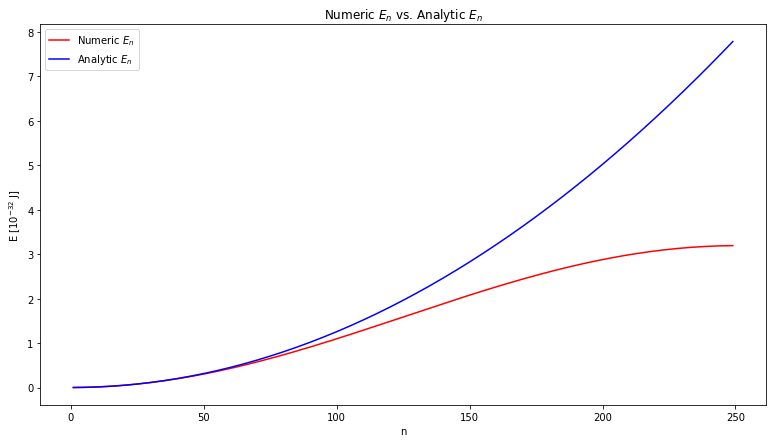

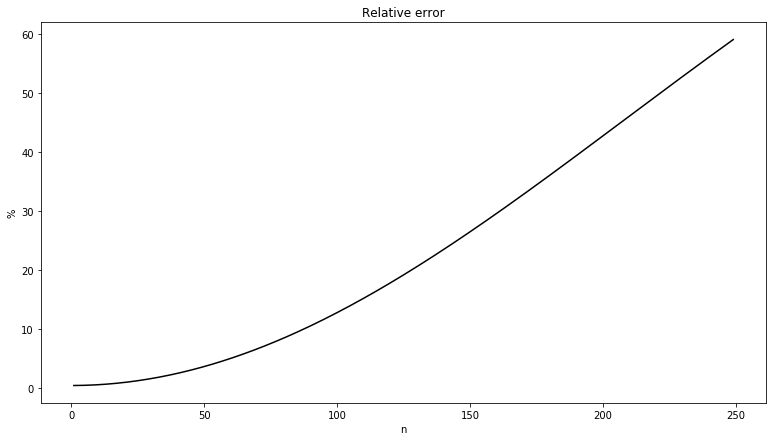

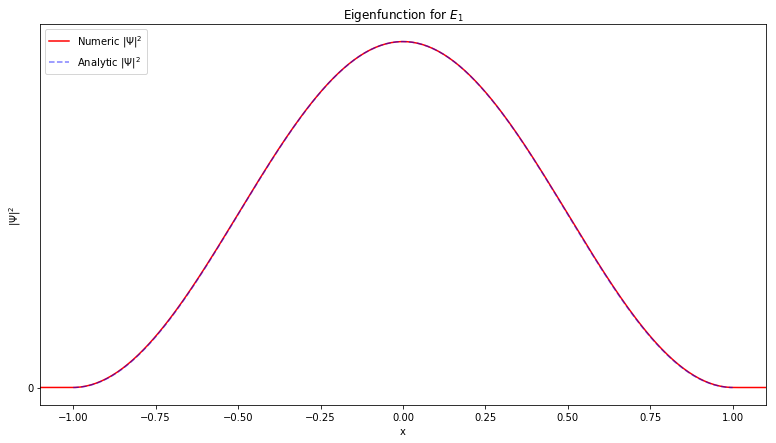

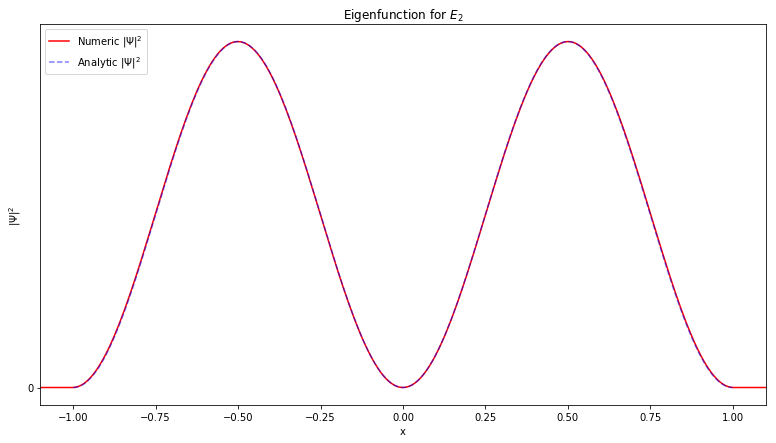

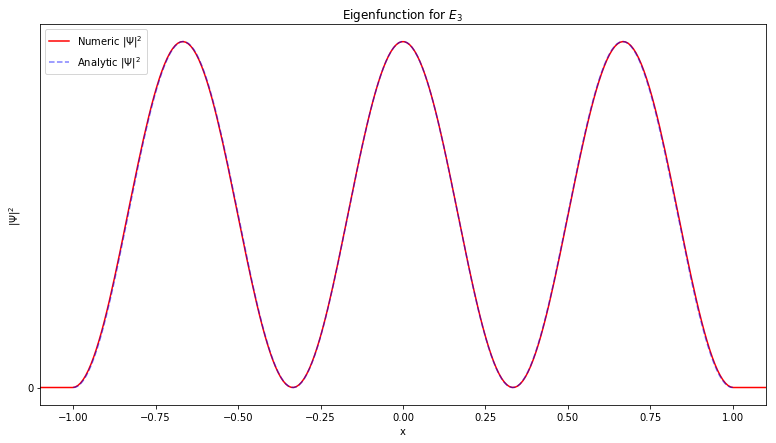

In [249]:
Plot_Numerov(start_x=-2,end_x=2,steps_x=500,v=10**10)

# Energiespectrum $H_2$

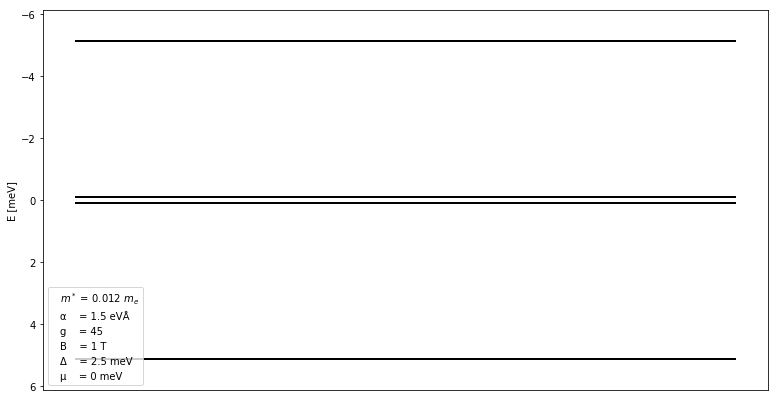

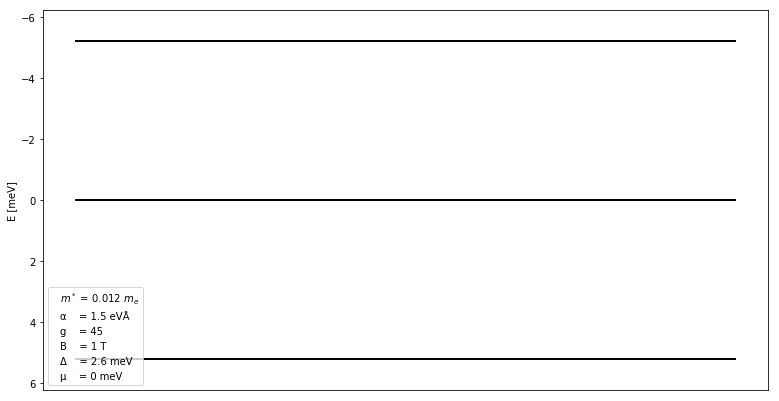

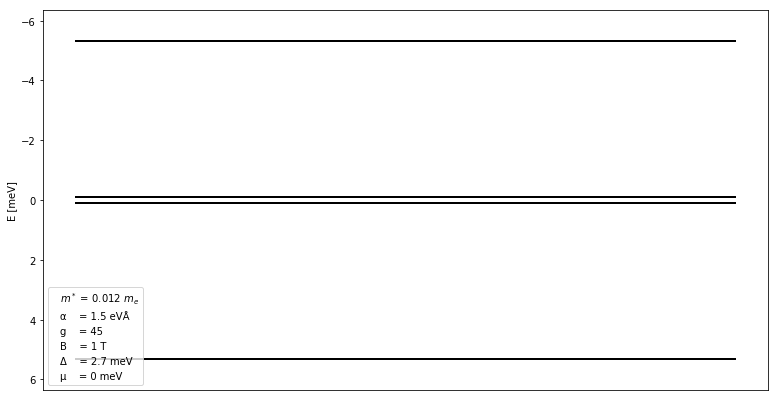

In [293]:
Plot_E(m=0.012,g=45,B=1,delta=2.5,alpha=1.5,mu=0,l=0.5,n=500,d=0.05, v=100,delta_zero_mode=False)
Plot_E(m=0.012,g=45,B=1,delta=20,alpha=1.5,mu=0,l=0.5,n=500,d=0.05, v=100,delta_zero_mode=True)
Plot_E(m=0.012,g=45,B=1,delta=2.7,alpha=1.5,mu=0,l=0.5,n=500,d=0.05, v=100,delta_zero_mode=False)

# Majorana modes wavefunction spin up

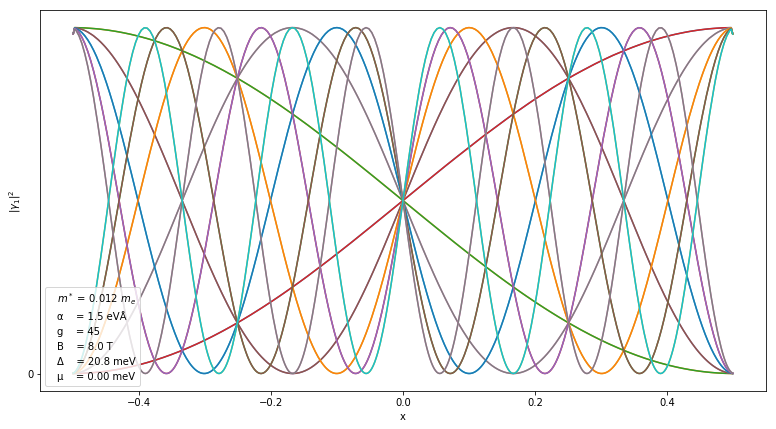

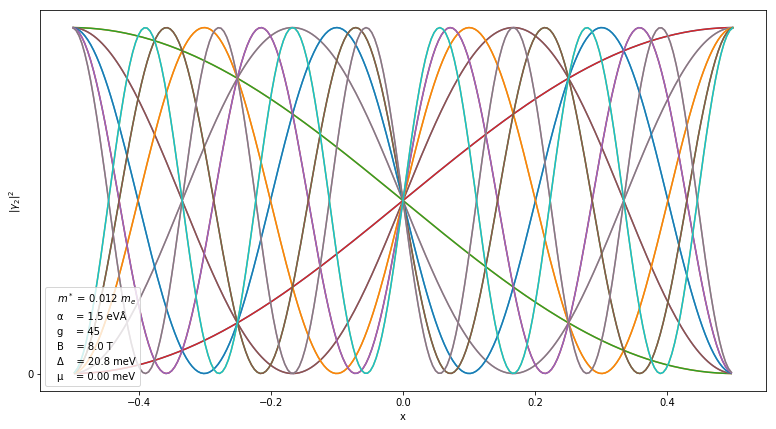

In [76]:
Plot_wavefunction(m=0.012,g=45,B=8,delta=20,alpha=1.5,mu=0,l=0.5,n=500,d=0.05, v=100,delta_zero_mode=True,spin='up')

# Majorana modes wavefunction spin down

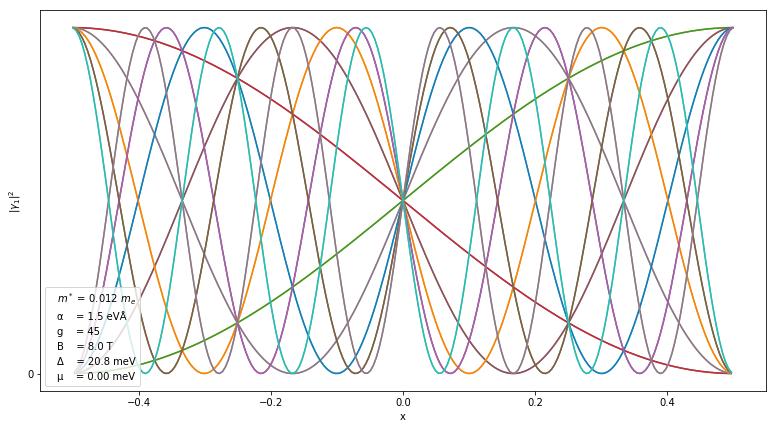

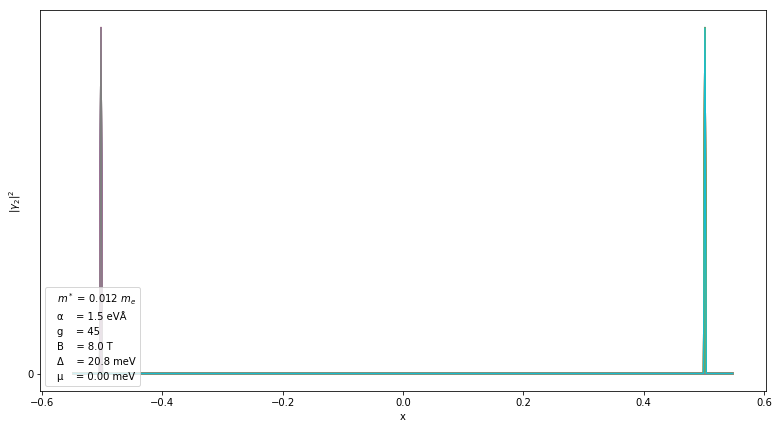

In [77]:
Plot_wavefunction(m=0.012,g=45,B=8,delta=20,alpha=1.5,mu=0,l=0.5,n=500,d=0.05, v=100,delta_zero_mode=True,spin='down')

<IPython.core.display.Javascript object>


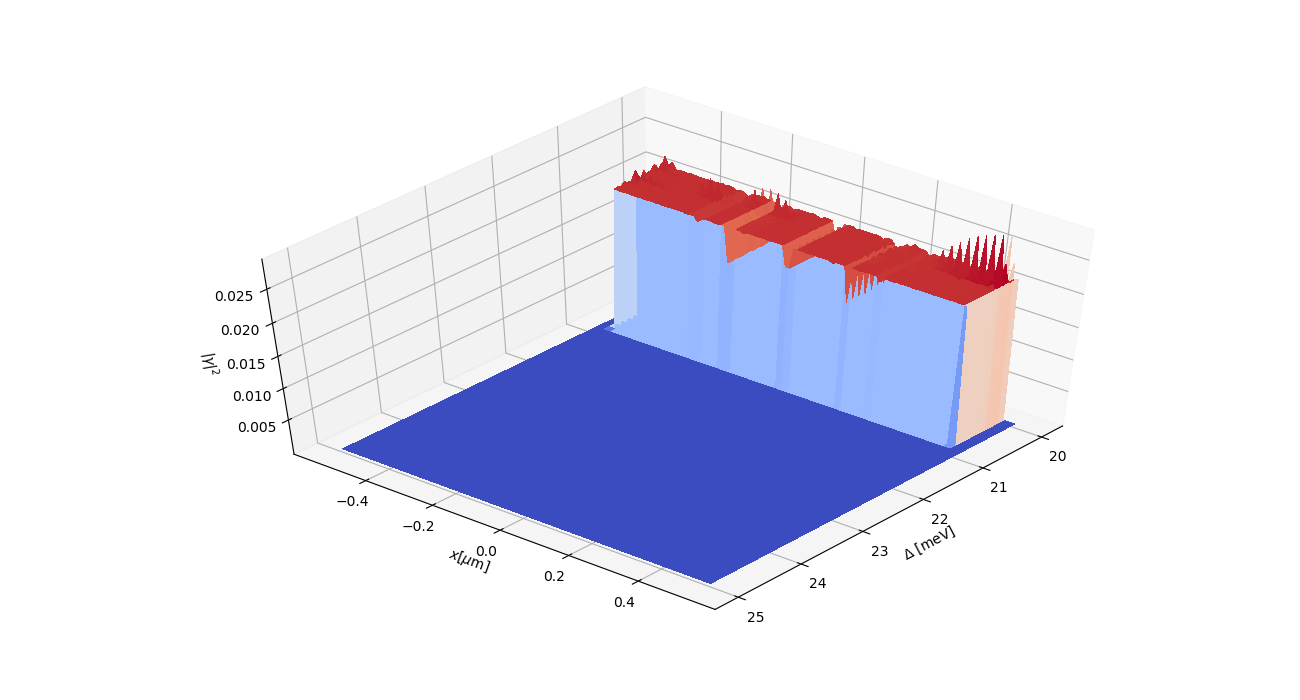

<IPython.core.display.Javascript object>


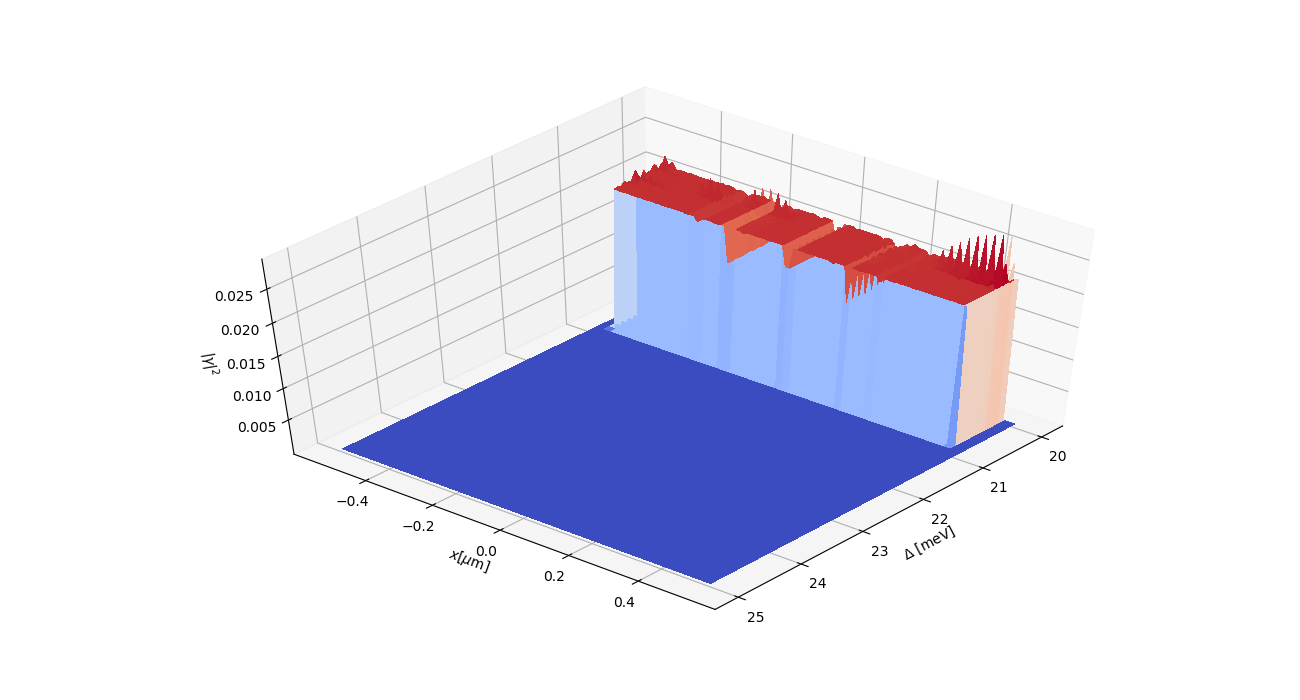

<IPython.core.display.Javascript object>


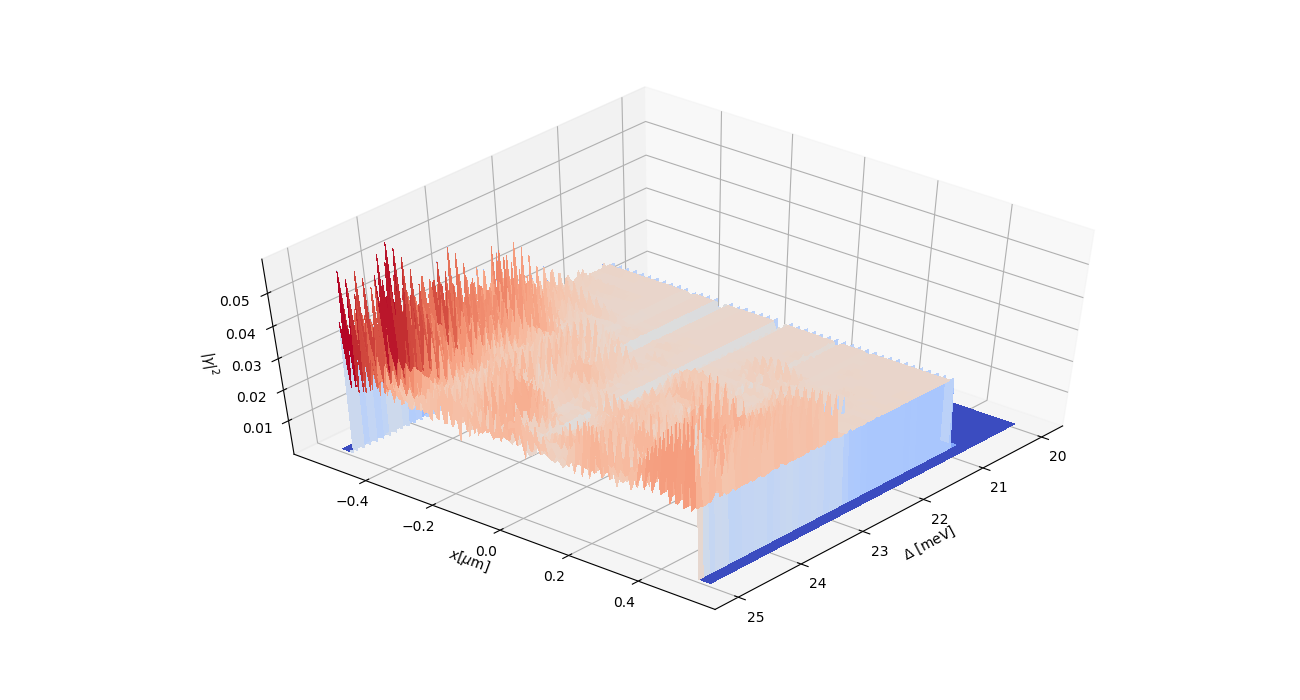

<IPython.core.display.Javascript object>


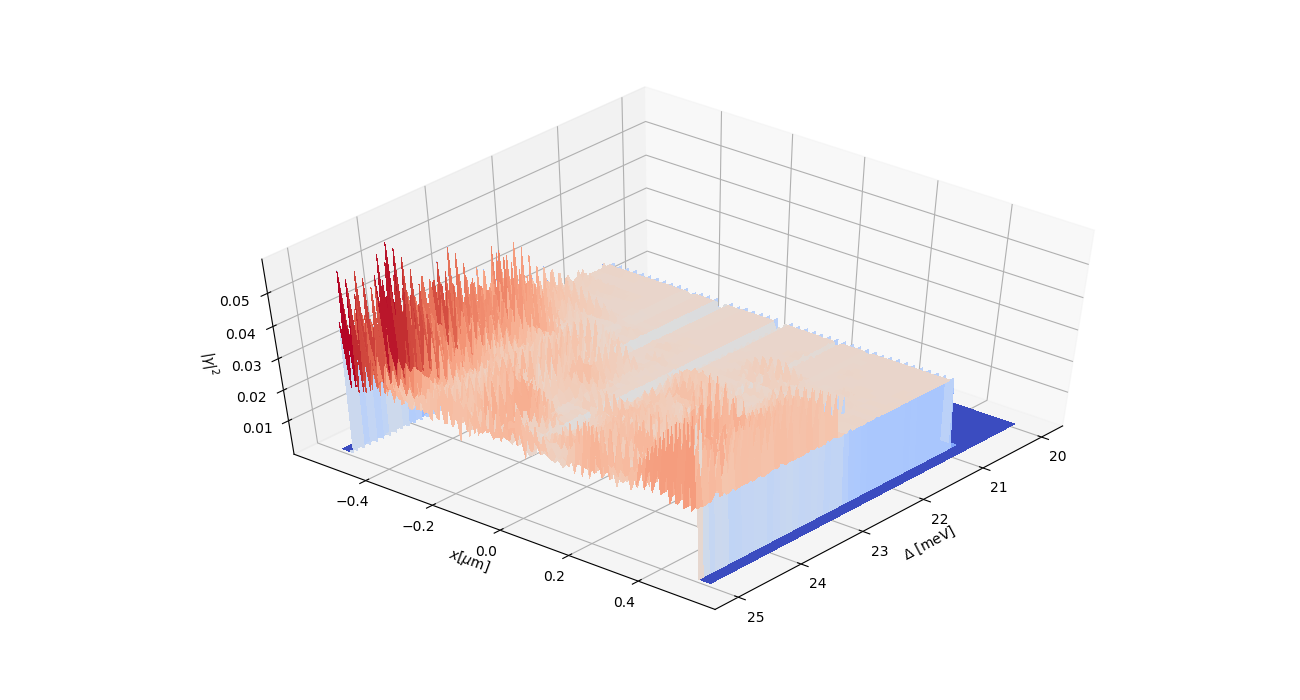

In [75]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
%matplotlib notebook


Plot_wavefunction_3d(m=0.012,g=45,B=8,alpha=1.5,mu=0,l=0.5,n=100,d=0.05, v=100,start_delta=20,end_delta=25,steps_delta=150,mode_number=0)
Plot_wavefunction_3d(m=0.012,g=45,B=8,alpha=1.5,mu=0,l=0.5,n=100,d=0.05, v=100,start_delta=20,end_delta=25,steps_delta=150,mode_number=1)
Plot_wavefunction_3d(m=0.012,g=45,B=8,alpha=1.5,mu=0,l=0.5,n=100,d=0.05, v=100,start_delta=20,end_delta=25,steps_delta=150,mode_number=2)
Plot_wavefunction_3d(m=0.012,g=45,B=8,alpha=1.5,mu=0,l=0.5,n=100,d=0.05, v=100,start_delta=20,end_delta=25,steps_delta=150,mode_number=3)